In [2]:
from sklearn.datasets import fetch_openml


In [3]:
#Load the data
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()


#Define data and targets
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

c:\Python310\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784)
(70000,)


- There are 70,000 images for each row, each containing 784 features. 
- Each feature represents one pixel intensity, and since each image is 28x28, we have 784 pixels for every image. 
- Below we plot one instance.

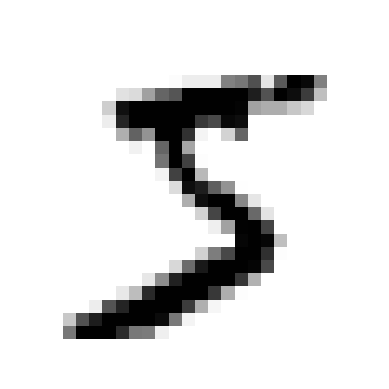

0    5
Name: class, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']


In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt


example_digit = X.head(1)
example_digit_image = example_digit.values.reshape(28,28) #allows us to convert from one flat array of 784 elements, to a 2D arrays of 28 elements each. 

plt.imshow(example_digit_image, cmap="binary")
plt.axis("off")
plt.show()

label_example = y.head(1)
print(label_example)



We note that the label is a string. Most MLs expet numbers so we cast all labels to an integer below. 
Following on, we define our training and test sets. The MNIST dataset is already split, whereby the first 60000 are the training set and the last 10000 are the test set. 
The entire dataset are shuffled, which guarantees all cross-validation folds will be similar and prevents similar instances from appearing in a row which can lead to poor performance.

In [5]:
import numpy as np

#convert label to integer type
y = y.astype(np.uint8)

#define training and test data sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]


First we simplify the problem by using a binary classifier, which will only identify the number 5. We will be using the stochastic gradient descent classifier (SGD), which is efficient at computing large datasets because it deals with training instances independantly. 

In [6]:
from sklearn.linear_model import SGDClassifier

#target vectors
y_train_5 = (y_train ==5)
y_test_5 = (y_test == 5)

#classifier
sgd_clf = SGDClassifier(random_state=42)  #keeps results reproduceable by selecting random state
sgd_clf.fit(X_train, y_train_5)

#test predicition on first element which we know is 5 from above
sgd_clf.predict(example_digit)

array([ True])

The model predicted correctly, now we want to evaluate the model with some performance measures. 

In [7]:
'''K-fold validation'''

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring = "accuracy")

from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) #instead of returning accuracy like above, returns the clean predictions themselves for each training instance. Clean = predion made by model which didn't see that instance during training. 

In [8]:
'''Confusion Matrix'''

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Generally, each row represents an actual class, while each column represents a predicted class.

[true negatives, false positives],
[false negatives, true positives]

so we have:

true negatives = 53892
false positves = 687
false negatives = 1891
true positives = 3530


a perfect classifier would be diagonal matrix.

In [11]:
'''Precision and Recall'''

from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred)) # =3530/3530 + 687
print(recall_score(y_train_5, y_train_pred)) # =3530/3530 + 1891


#we can combine both metrics above into a F score, which favors classifiers that has a similar precision and recall, returning a high F is both metrics are high. 

from sklearn.metrics import f1_score
print(f1_score(y_train_5, y_train_pred))



0.8370879772350012
0.6511713705958311
0.7325171197343846


we conclude, when the ML claims an image represents a 5, it's correct 83.7% of the time. 
moreoever, it only detects 73.3% of the 5's. 

the SGD classifier computes a score for each instance based on a decision function. If that score is greater than the threshold, it assigns the instance to the positive class, else assigns to negative class. 

scikit doesn't let you set the thresholds directly, but does provide access to the decision scores used in predicitions. Thus, allowing us to set an arbitrary threshold as presented below. 

In [19]:
#returns the score determined by the decsision function
y_scores = sgd_clf.decision_function(example_digit)
print(y_scores)

#this is the default threshold used by the predict() method. 
threshold = 80000
y_example_digit_prediction = (y_scores > threshold)
print(y_example_digit_prediction)


[2164.22030239]
[False]


if we were to set the threshold to 8000, the result would return false, which confirms raising the threshold decreases recall (misses a true value of 5).

to determine an optimal threshold, we again generate y_scores with the cross_val_predict method but instad use the decsision function method. 

In [20]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

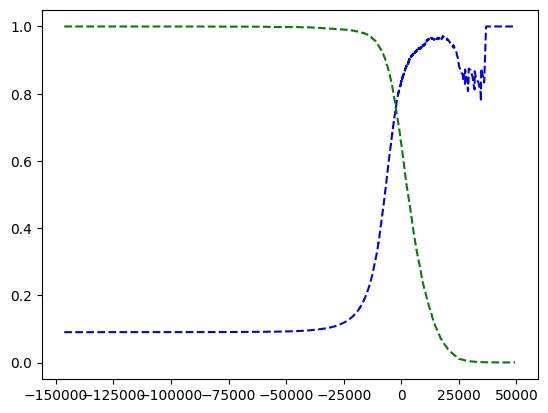

In [24]:
from sklearn.metrics import precision_recall_curve

#computes precision and recall for all possible threshold
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

#plot precision and recall as functions of the threshold values. 
def plot_precision_recall_vs_threshold(precision, recalls, thresholds):
    plt.plot(thresholds, precision[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()


Another method to determine the best threshold for a project, is to plot an ROC curve.

Stands for receiver operating characteristic, which plots the true positive rate (another name for recall) vs false positive rate (FPR). 

In other words, plots the sensitivity (recall) vs [1 - specificty]


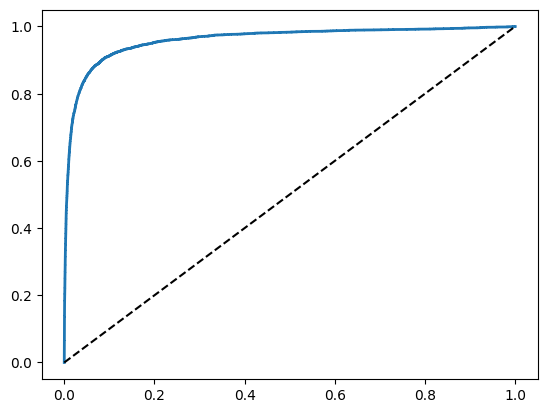

In [26]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')

plot_roc_curve(fpr, tpr)
plt.show()

We observe another trade-off, the higher recall, the more false positives the classifier produces. 

A good classifier stays far from the diag line, towards the top left corner. 

If we wanted to compare classifiers, is the measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas purely random classifier wwill have a ROC AUC equal to 0.5

In [27]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

we train a random forest classifier and compare its ROC curve and ROC AUC score to the SGD classifier. 
- first we get scores for each instance in the training set
- cannot use decision_function() as doesn't exist, instead we use predict_proba() method. 
- classifiers generally have one or the other, or both methods      


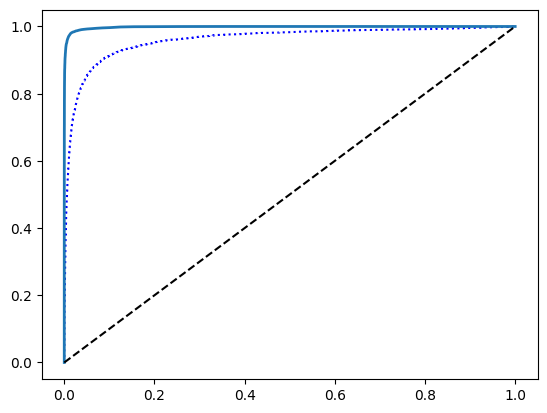

In [28]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)


plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest,tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show() 

we conclude that the random forest classifier is superior to the SGD classifier because it's ROC curve is much closer to the top left corner and it has a greater AUC. 